## Exploratory Analysis of Quiz Bowl Input and the Quality of Speech Recognition 

Works in both Python2.  The below dependencies are needed; all pip installable.  PocketSphynx needed for deciphering sound data locally, and installation only worked on Python2 on MacOS.

TODOs:  Explore "Slow" vs "Fast" TTS speech.  Explore human-speech and not TTS.  Explore Google or MSFT Speech Recognition.  Account for Unicode in data.  

In [1]:
#math

import pandas
from scipy import stats
import numpy as np
from collections import Counter
from scipy import stats

#wrangling + plotting
import csv
import glob 
import matplotlib.pyplot as plt
import pprint

#speech
from gtts import gTTS
import speech_recognition as sr
import subprocess
import spacy
nlp = spacy.load('en')
import nltk.translate.bleu_score as bleu

## Speech Recognition

Data used:

qb/data/questions/expo/2015_hsnct.csv
qb/data/questions/expo/2015_jennings.csv
qb/data/questions/expo/2015_jennings.power.csv
qb/data/questions/expo/2016_hsnct.csv
qb/data/questions/expo/2016_naacl.csv
qb/data/questions/expo/2017_hsnct.csv
qb/data/questions/expo/2017_hsnct.power.csv

### Store Text in Dict by Document and Convert Text to Speech 

In [2]:
%%time
#~7 minutes

#stores questions by document
storage = dict()

#loop through each document (only CSV files in the QB data folder)
for each_file in glob.glob('qb/data/questions/expo/*.csv'):
    
    print (each_file)
    
    with open(each_file) as f:
        file_storage = []
        data = csv.reader(f)
        
        #dump header
        header = next(data)
        if "text" in header:
            #find proper index of question text
            correct_col = header.index("text")
            
            #keep track of question number
            counter = 0
            for line in data:
                try:
                    text = (line[correct_col])
                    file_storage.append(text)
                    
                    #convert into audio with gTTS, save it to mp3, convert it to WAV
                    sentTTS = gTTS(text, lang='en', slow=True)
                    file_name = each_file + "_" +str(counter) 
                    sentTTS.save(file_name+".mp3")
                    subprocess.call(['ffmpeg', '-i', file_name+".mp3",
                    file_name + '.wav'])
                    counter += 1   
                
                except:
                    print ("Issue caused by " + str(line))                      
            storage[each_file] = file_storage

qb/data/questions/expo/2015_hsnct.csv
qb/data/questions/expo/2015_jennings.csv
qb/data/questions/expo/2015_jennings.power.csv
qb/data/questions/expo/2016_hsnct.csv
qb/data/questions/expo/2016_naacl.csv
Issue caused in ['57', 'Woodrow Wilson', "Along with Austin Garretson, this president averted a railroad strike by negotiating for an eight-hour workday in what would become the Adamson Act. He appointed his advisor, Louis Brandeis, to the Supreme Court, and he called his economic agenda for the country (*) \xe2\x80\x98New Freedom.' During this man's presidency, A. Mitchell Palmer conducted a series of raids to deport anarchists after the passage of an Espionage Act. For 10 points, name this president who led the American entry into World War One.", 'test']
Issue caused in ['66', 'Prion', 'A condition caused by an example of this entity can be diagnosed by the presence of 14-3-3 protein in the cerebrospinal fluid. The replication of these entities can be explained by the heterodimer mode

### Decipher Each Audio File with PocketSphinx and Calculate Bleu Score

In [3]:
%%time
#~51 minutes

#keep track of bleu score
processed_speech = []

record_data = dict()
for each_file in glob.glob('qb/data/questions/expo/*.wav'):
    r = sr.Recognizer()
    with sr.AudioFile(each_file) as source:              
        audio = r.record(source)
        
    try:
        #PocketSphinx is used locally to decipher the audio
        audio_data = r.recognize_sphinx(audio) 
        #find the appropriate file and question number.  WAV files contain this information
        #lower for bleu score calculation
        text_data = storage[each_file[0:each_file.rfind('_')]][int(each_file [each_file.rfind('_')+1:each_file.rfind('.')])].lower() 
        #calculate bleu score with NLTK
        processed_speech.append(bleu.sentence_bleu(audio_data, text_data))
    except:
        print ("failed on " + each_file)
    

failed on qb/data/questions/expo/2017_hsnct.csv_100.wav
failed on qb/data/questions/expo/2017_hsnct.csv_94.wav
failed on qb/data/questions/expo/2017_hsnct.csv_95.wav
failed on qb/data/questions/expo/2017_hsnct.csv_99.wav
CPU times: user 1h 6min 27s, sys: 48.6 s, total: 1h 7min 16s
Wall time: 1h 7min 48s


## Results

DescribeResult(nobs=373, minmax=(0.43659728580269025, 0.8408964152537145), mean=0.57152223028752969, variance=0.010771011427074184, skewness=0.38736367341835165, kurtosis=-1.3862072804350436)


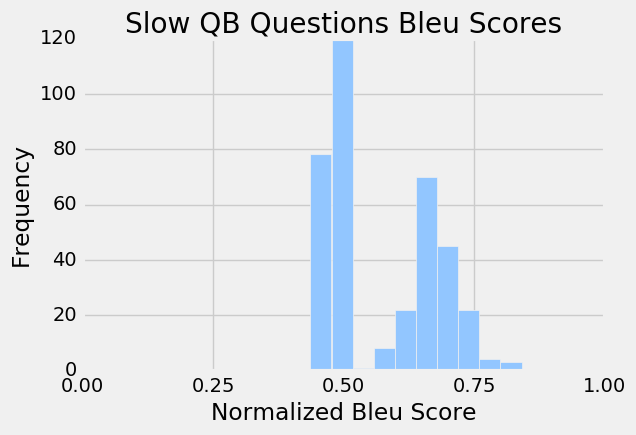

In [13]:
print stats.describe(processed_speech)

plt.title("Slow QB Questions Bleu Scores")
plt.hist (processed_speech)
plt.style.use('seaborn-pastel')
plt.xlabel("Normalized Bleu Score")
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Frequency")
plt.show()

## Exploration of Quiz Bowl Data

### Word Length

DescribeResult(nobs=18912, minmax=(1, 24), mean=5.0013219120135366, variance=8.0350572128496474, skewness=0.9749458691931133, kurtosis=1.0325312223312677)


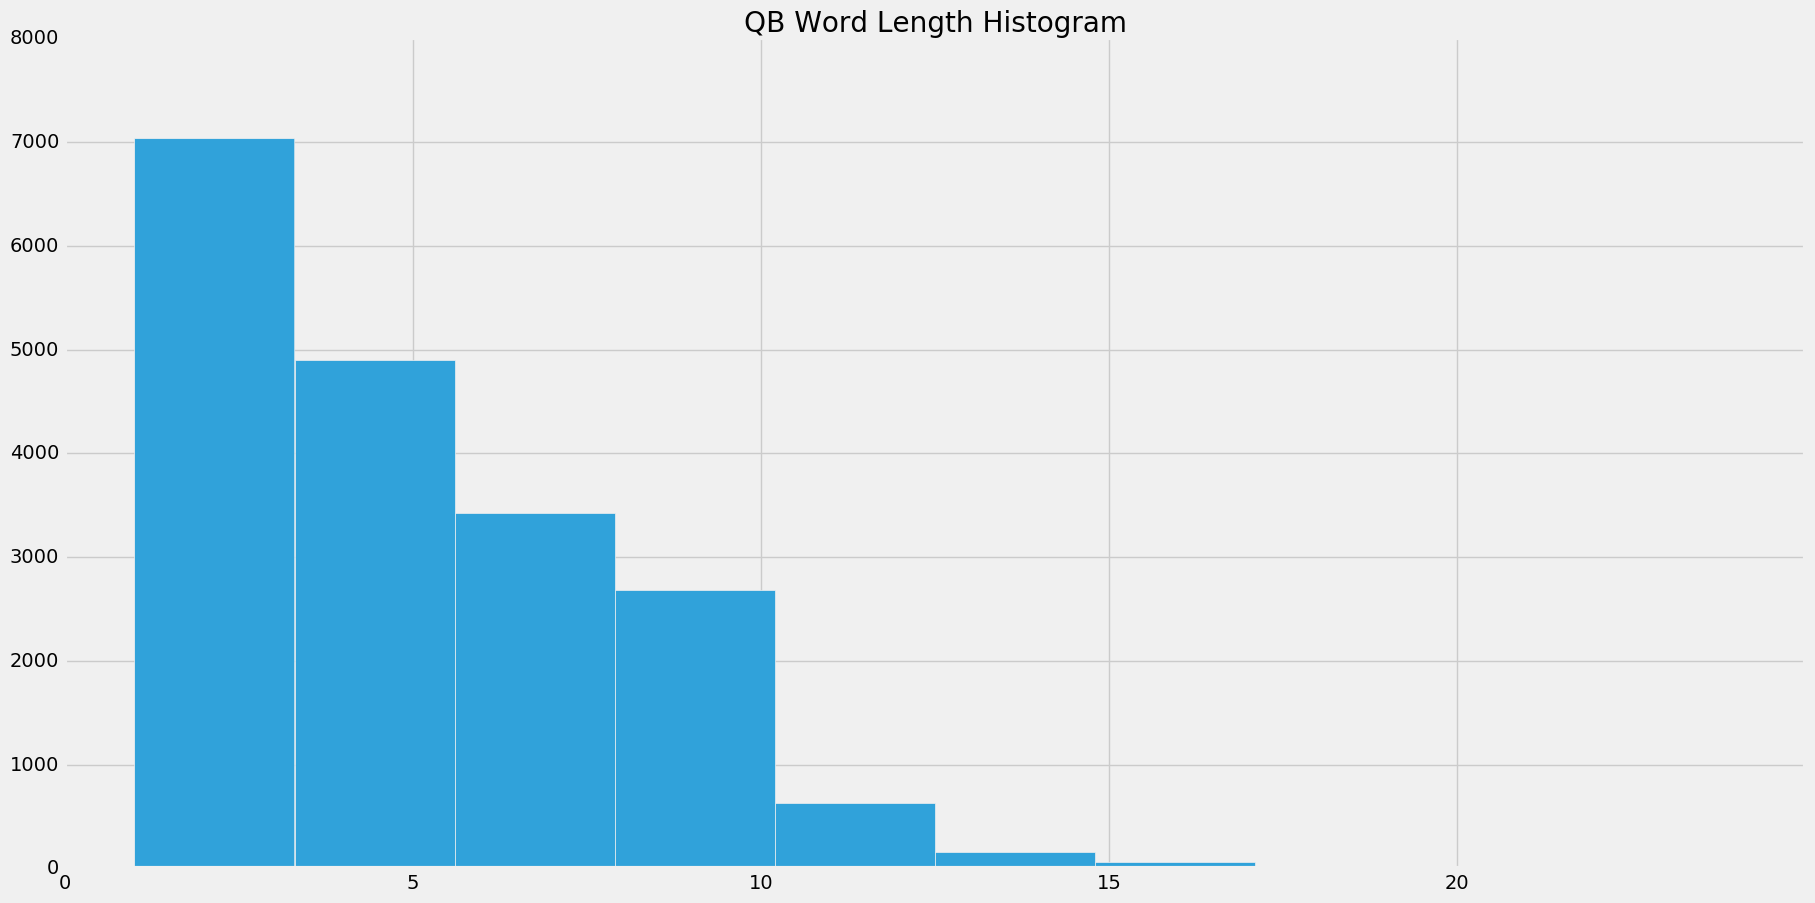

In [5]:
word_len = []
for doc in storage:
    for line in storage[doc]:
        for word in line.split():
            word_len.append(len(word))

print (stats.describe(word_len))

plt.figure(figsize=(20, 10))
plt.hist(word_len)
plt.title("QB Word Length Histogram")
x_ticks = [0, 5, 10, 15, 20]
plt.xticks(x_ticks)
plt.show()

### Word Count

['the',
 'of',
 'a',
 'this',
 'in',
 'to',
 'and',
 '10',
 'by',
 'is',
 'For',
 'that',
 'was',
 'This',
 'The',
 'his',
 'for',
 'who',
 'which',
 'with']


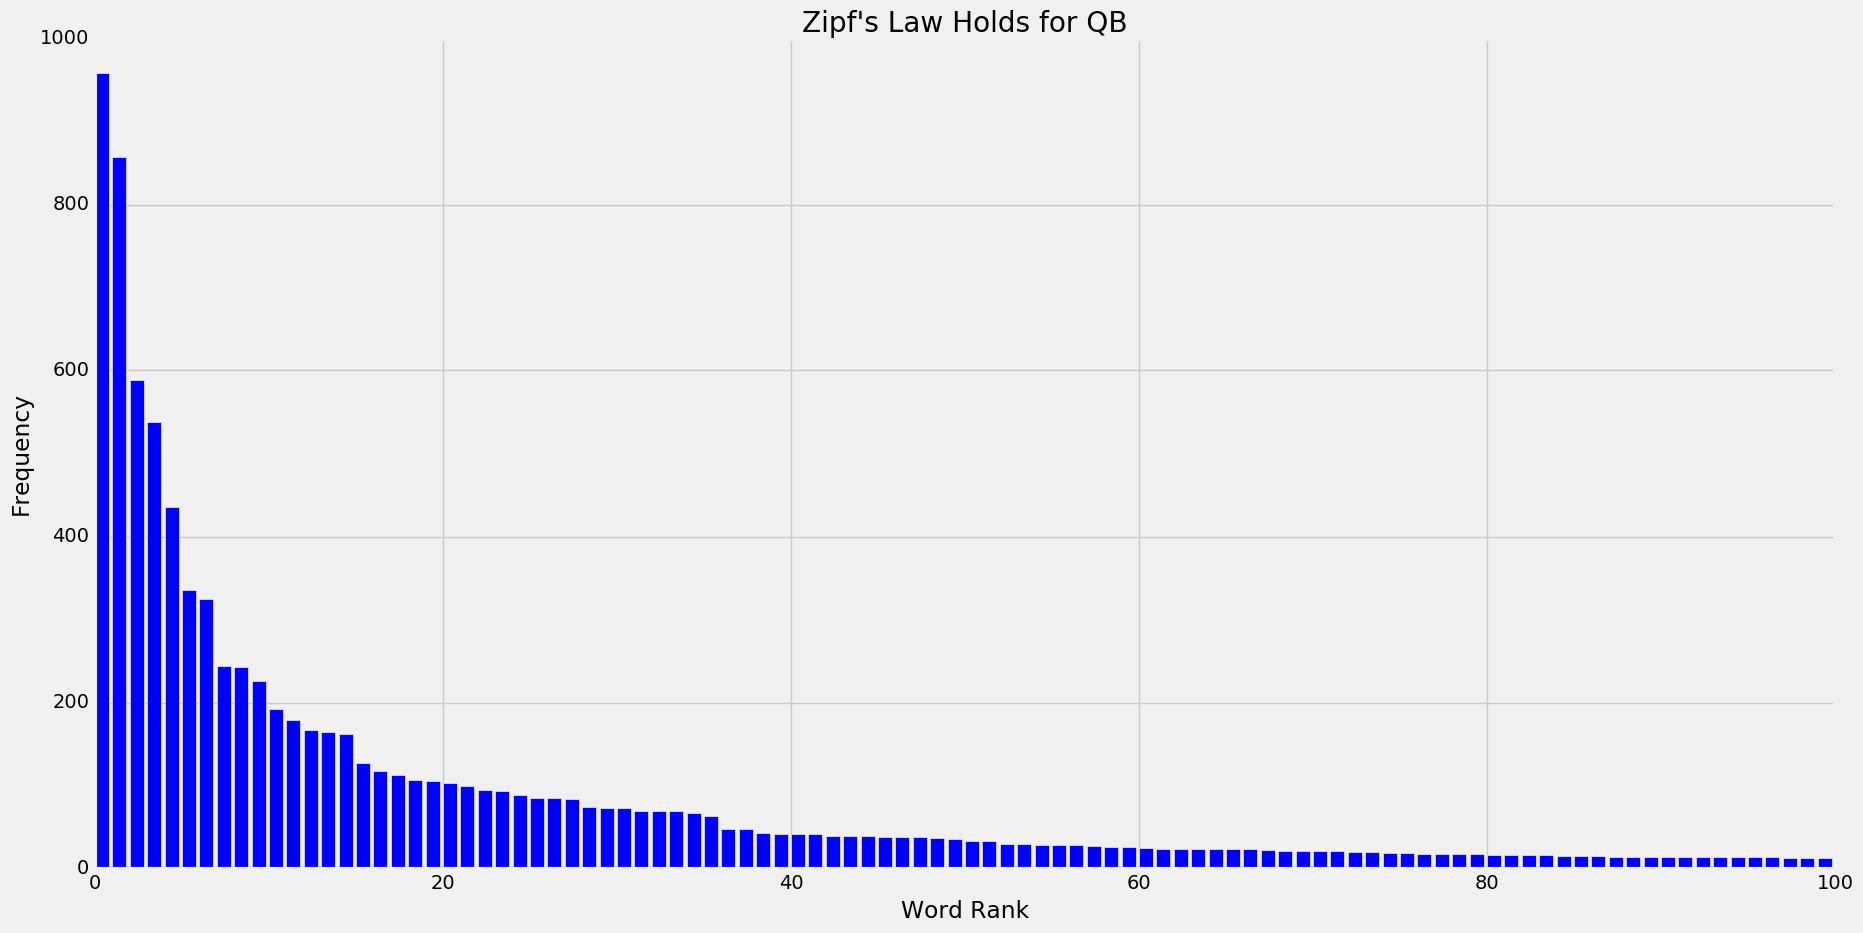

In [6]:
#dump everything into single list and run Counter on this.
single_list = []
for doc in storage:
    for line in storage[doc]:
        single_list.append(line) 
wordcount = Counter(' '.join(single_list).split())

a = [x[0] for x in wordcount.most_common(100)]
y = [x[1] for x in wordcount.most_common(100)]


pprint.pprint(a[:20])

x = np.arange(len(a))


plt.figure(figsize=(20, 10))
plt.title("Zipf's Law Holds for QB")
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.bar(x, y, align = 'edge')
plt.show()